In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 3 May 2023
# Description:
#     this script compares methods of calculate the OHC and surface heat flux integrated over the continental shelf
#     - update to xarray open_mfdataset from open_dataset brought new functions more efficient to calculate model layer thickness (dz)
# and ocean heat content tendencies (rho0*Cp*dT/dt). 

# - update 23/8/23: re-ran waom10 saving daily outputs in 5-days files.
# I suspect that the monthly files with unequal number of time-fields 
# causes differences in the dt for his and avg files, reflected in the 
# residue for the Antarctic shelf seas heat budget.

In [2]:
# read nc output from WAOM 10km run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw
import cmocean

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:38879' processes=28 threads=28>


In [4]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'

In [5]:
    %%time
    
    # using xr.open_mfdataset
    
    vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]
    
    ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"
    
    #- preserving 5-days avgs
    # zeta = ds.variables["zeta"] 
    temp = ds.variables["temp"] 
    # salt = ds.variables["salt"]
    # shflux = ds.variables["shflux"] 
    # ssflux = ds.variables["ssflux"]
    # m = ds.variables["m"]
    # HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
    # HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
    # Hvom = ds.variables["Hvom"] 
    # Huon = ds.variables["Huon"] 
    # time_avg = ds.variables["ocean_time"] 
    ice_draft = ds.variables["zice"]
    
    mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
    mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
    
    print("Vtransform=2")
    #  New formulation (Vtransform(ng) = 2):
    #
    #         z_w(x,y,s,t) = zeta(x,y,t) + [zeta(x,y,t)+ h(x,y)] * Zo_w
    #                 Zo_w = [hc * s(k) + C(k) * h(x,y)] / [hc + h(x,y)]
    hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
    z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho 
    
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
    z_w = ds.zeta + (ds.zeta + hwater) * Zo_w 
    
    dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
    
    lat_rho = dg.variables["lat_rho"]
    lon_rho = dg.variables["lon_rho"]
    lat_u = dg.variables["lat_u"]
    lon_u = dg.variables["lon_u"]
    lat_v = dg.variables["lat_v"]
    lon_v = dg.variables["lon_v"]
    pm = dg.variables["pm"]
    pn = dg.variables["pn"]
    h = dg.variables["h"]
    zice = dg.variables["zice"]
    
    ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
    ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset
    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    
    ds.close()
    dg.close()
    
    # calculate surface sigma_theta (potential density)
    # sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000
    area=np.divide(1,pm*pn)

Vtransform=2
CPU times: user 24.4 s, sys: 5.8 s, total: 30.2 s
Wall time: 50.4 s


In [6]:
###

In [7]:
    # load horizontal diffusion of heat calculated online:
    	# float temp_hdiff(ocean_time, s_rho, eta_rho, xi_rho) ;
    
    ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_dia_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)
    temp_hdiff = ds.variables["temp_hdiff"] 
    temp_vdiff = ds.variables["temp_vdiff"] 
    # temp_sdiff = ds.variables["temp_sdiff"]  #"potential temperature, horizontal S-diffusion rotated tensor term"
    temp_hadv = ds.variables["temp_hadv"] 
    temp_vadv = ds.variables["temp_vadv"] 
    ds.close()

In [8]:
    # %%time
    # # method 2 to calculate Dz:
    # # z_w=z_w.chunks(chunks={'eta_rho': '200MB'}) # couldn't change chunks.
    
    # Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
    # print(z_w.shape, Z_w.shape)
    # dz = np.diff(Z_w,axis=1)


In [10]:
# # convert dz to xarray:
# months=np.arange(0,365)*(1/30.41667)
# # save to netcdf file:
# coordinatesC=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)), eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))

# dz_xr = xr.DataArray(dz, coords = coordinatesC, dims = ['ocean_time','s_rho','eta_rho','xi_rho'])


In [11]:
    temp_vadv.load()
    temp_hadv.load()

<xarray.Variable (ocean_time: 365, s_rho: 31, eta_rho: 560, xi_rho: 630)>
array([[[[ 1.67195776e-06,  1.67195776e-06, -1.55184694e-06, ...,
          -5.58577938e-07, -3.37030087e-07, -3.37030087e-07],
         [ 1.67195776e-06,  1.67195776e-06, -1.55184694e-06, ...,
          -5.58577938e-07, -3.37030087e-07, -3.37030087e-07],
         [ 5.72446106e-06,  5.72446106e-06,  6.07138702e-07, ...,
          -3.50623537e-07, -4.94417066e-07, -4.94417066e-07],
         ...,
         [-1.10337260e-06, -1.10337260e-06, -1.98637213e-06, ...,
          -1.53627491e-06,  3.07586720e-06,  3.07586720e-06],
         [ 5.40510018e-06,  5.40510018e-06, -4.85127293e-06, ...,
           3.81703330e-06, -3.25185852e-06, -3.25185852e-06],
         [ 5.40510018e-06,  5.40510018e-06, -4.85127293e-06, ...,
           3.81703330e-06, -3.25185852e-06, -3.25185852e-06]],

        [[ 2.82995120e-06,  2.82995120e-06, -2.41523503e-06, ...,
          -5.15553950e-07, -2.73867641e-07, -2.73867641e-07],
         [ 2.82995120e-06,  2.82995120e-06, -2.41523503e-06, ...,
          -5.15553950e-07, -2.73867641e-07, -2.73867641e-07],
         [ 4.88152500e-06,  4.88152500e-06, -1.31782642e-07, ...,
          -3.13384078e-07, -3.25401231e-07, -3.25401231e-07],
...
          -3.26827139e-05, -8.35643459e-06, -8.35643459e-06],
         [ 4.08480417e-07,  4.08480417e-07, -3.17359991e-06, ...,
           3.71903770e-05,  6.07571783e-05,  6.07571783e-05],
         [ 4.08480417e-07,  4.08480417e-07, -3.17359991e-06, ...,
           3.71903770e-05,  6.07571783e-05,  6.07571783e-05]],

        [[ 4.63790493e-05,  4.63790493e-05,  6.02087748e-05, ...,
           3.34388496e-05,  3.46523084e-05,  3.46523084e-05],
         [ 4.63790493e-05,  4.63790493e-05,  6.02087748e-05, ...,
           3.34388496e-05,  3.46523084e-05,  3.46523084e-05],
         [-2.61633177e-05, -2.61633177e-05, -8.93851848e-06, ...,
           1.46763578e-05,  2.08350975e-05,  2.08350975e-05],
         ...,
         [-4.42021928e-06, -4.42021928e-06, -1.29115560e-05, ...,
          -6.53078496e-06,  1.41635974e-05,  1.41635974e-05],
         [ 1.12959879e-05,  1.12959879e-05,  2.83039644e-05, ...,
           4.32215566e-05,  1.01863363e-04,  1.01863363e-04],
         [ 1.12959879e-05,  1.12959879e-05,  2.83039644e-05, ...,
           4.32215566e-05,  1.01863363e-04,  1.01863363e-04]]]],
      dtype=float32)
Attributes:
    long_name:  potential temperature, horizontal advection term
    units:      Celsius second-1
    time:       ocean_time
    field:      temp_hadv, scalar, series

In [ ]:
temp_vadv_dz = temp_vadv*dz_xr
temp_hadv_dz = temp_hadv*dz_xr

In [ ]:
plt.pcolormesh(temp_vadv_dz.sum('s_rho').mean('ocean_time'), cmap='bwr', vmin=-0.0001, vmax=0.0001)
plt.colorbar()

In [ ]:
# plt.pcolor(temp_hadv_dz.sum('s_rho').mean('ocean_time'), cmap='bwr', vmin=-0.0001, vmax=0.0001)
# plt.colorbar()

In [ ]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'


In [ ]:
contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m_v3', allow_pickle=True)
contour_masked_above_CF = np.load(files_path + 'WAOM10_contour_masked_above_CF_v3', allow_pickle=True)


In [12]:
# determine constants:
# rho0 = 1025 # kg. m-3
# Cp = 3989.245 # J.kg-1.degC-1
# Tf = -1.95 # degC
# use same value as ACCESS-OM2
rho0=1035
Cp=3992.1
# Tf = -1.95 # degC
Tf =  -3.534879684448242

# plt.pcolormesh(ma.masked_where(contour_masked_above == -1000, temp.isel(s_rho=0).mean('ocean_time')-Tf), vmin=0, vmax=4)
# plt.colorbar()

### Calculate temp_rate from temp snapshots:

In [16]:
%%time

ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_his_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, decode_times=False) #, chuncks="auto", concat_dim="ocean_time"

#- preserving 5-days avgs
temp_snap = ds.variables["temp"] ##+273.15 (changing to Kelvin didn't change any results)
time_snap = ds.variables["ocean_time"]
ds.close()


CPU times: user 21.5 s, sys: 4.24 s, total: 25.8 s
Wall time: 44.2 s


In [17]:
%%time

# calculate dT/dt by differentiating temp_snap:
temp_Rate = np.empty(temp_snap.shape)
dT = np.empty(temp_snap.shape)

# needs the initial conditions:
ds = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_11-20yr/ocean_rst.nc')
temp_ini = ds.variables["temp"].isel(ocean_time=8, two=0) ##+273.15 (changing to Kelvin didn't change any results) # 5-days mean
time_ini = ds.variables["ocean_time"].isel(ocean_time=8)
ds.close()

    
tlen = len(temp[:,0,0,0])

CPU times: user 223 ms, sys: 71.6 ms, total: 294 ms
Wall time: 551 ms


In [18]:
%%time

# transform to DataArray
temp_snap = xr.DataArray(temp_snap)
temp_ini = xr.DataArray(temp_ini)

# - append temp_ini to first time index in temp_snap and then do diff
temp_snap = xr.concat([temp_ini,temp_snap], 'ocean_time')
dT = temp_snap.diff('ocean_time')
print(dT.shape)

# 
# dt = 5*86400 # 5-days in seconds
dt = 86400 # 1day
temp_Rate = np.divide(dT, dt)
temp_Rate = xr.DataArray(temp_Rate)
# temp_Rate=temp_Rate.rename({'dim_0':'ocean_time','dim_1':'s_rho','dim_2':'eta_rho','dim_3':'xi_rho'})

print(dT.shape)

temp_Rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')

print(temp_Rate.shape)

(31, 560, 630, 365)
(31, 560, 630, 365)
(365, 31, 560, 630)
CPU times: user 241 ms, sys: 180 ms, total: 421 ms
Wall time: 457 ms


In [19]:
# calculate dt for avg/his timestamps:

dt_avg = np.diff(time_avg)
dt_snap = np.diff(time_snap)

plt.plot(np.arange(0,364),dt_avg/86400,'.b')

NameError: name 'time_avg' is not defined

In [ ]:
plt.plot(np.arange(0,364),dt_snap/86400,'.r')


### Calculate volume-integral of individual budget terms:

In [ ]:
plt.pcolormesh(h-abs(zice), vmin=0, vmax=0.5)
plt.colorbar()

In [ ]:
plt.pcolormesh(contour_masked_above)#, vmin=0, vmax=1)
plt.colorbar()

In [ ]:
# Define conditions to mask out (1) off the shelf, (2) land (see plots above)
condition1 = contour_masked_above == -1000
condition2 = (zice+h) <= 1

# Combine conditions with logical OR
combined_condition = condition1 | condition2


In [ ]:
%%time
temp_Rate.load()

In [ ]:
%%time

# use -1000 mask to compute integral of surface heat fluxes and ocean heat content tendency:
# temp_Rate=xr.DataArray(temp_Rate)
temp_rate = temp_Rate.transpose('ocean_time','s_rho','eta_rho','xi_rho')
dT = dT.transpose('ocean_time','s_rho','eta_rho','xi_rho')

## Integrated heat tendency and sfc heat flux terms to check heat budget closure*1
# 1. area-integral surface heat flux
tlen = len(temp_rate[:,0,0,0])
area_sum =  np.nansum(np.nansum(area,axis=1), axis=0)

shflux_int = np.empty((tlen))
for mm in np.arange(0,tlen):
    shflux_masked = ma.masked_where(combined_condition, shflux[mm,:]) # -1000 is just the mask for values south of 1500m isobath; not depths.
    shflux_area = shflux_masked*area
    shflux_int[mm] = np.nansum(np.nansum(shflux_area,axis=1), axis=0)
    #del shflux_area
    
# 2. volume-integral heat tendency
temp_rate_int = np.empty((tlen))
temp_rate_vol = np.empty(np.squeeze(temp_Rate[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_rate_dz = temp_Rate[mm,:]*dz[mm,:]
    temp_rate_vint = np.nansum(temp_rate_dz, axis=0)
    temp_rate_vint_masked =  ma.masked_where(combined_condition, temp_rate_vint)
    temp_rate_vol[mm,:] = temp_rate_vint_masked*area
    
    #del temp_rate_vint
    temp_rate_int[mm] = np.nansum(np.nansum(temp_rate_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
%%time
temp_hadv.load()
temp_vadv.load()
temp_hdiff.load()
temp_vdiff.load()
# temp_sdiff.load()

In [ ]:
# define sum of all RHS:
RHS_budget = temp_hadv + temp_vadv + temp_hdiff + temp_vdiff
RHS_budget_masked = ma.masked_where(combined_condition, RHS_budget.sum('s_rho').isel(ocean_time=0))

plt.pcolormesh(RHS_budget_masked)#, vmin=-1e-12, vmax=1e-12, cmap='coolwarm')
plt.colorbar()

In [ ]:
%%time
# integral with all RHS terms (as suggested by Wilkin)
RHS_budget_int = np.empty((tlen))
RHS_budget_vol = np.empty(np.squeeze(RHS_budget[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    RHS_budget_dz = RHS_budget[mm,:]*dz[mm,:]
    RHS_budget_vint = np.nansum(RHS_budget_dz, axis=0)
    RHS_budget_vint_masked =  ma.masked_where(combined_condition, RHS_budget_vint)
    RHS_budget_vol[mm,:] = RHS_budget_vint_masked*area
    RHS_budget_int[mm] = np.nansum(np.nansum(RHS_budget_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
%%time
# 3. heat tendency due to horizontal diffusion:
temp_hdiff_int = np.empty((tlen))
temp_hdiff_vol = np.empty(np.squeeze(temp_hdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hdiff_dz = temp_hdiff[mm,:]*dz[mm,:]
    temp_hdiff_vint = np.nansum(temp_hdiff_dz, axis=0)
    temp_hdiff_vint_masked =  ma.masked_where(combined_condition, temp_hdiff_vint)
    temp_hdiff_vol[mm,:] = temp_hdiff_vint_masked*area
    temp_hdiff_int[mm] = np.nansum(np.nansum(temp_hdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
%%time
# 4. heat tendency due to horizontal advection:
temp_hadv_int = np.empty((tlen))
temp_hadv_vol = np.empty(np.squeeze(temp_hadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hadv_dz = temp_hadv[mm,:]*dz[mm,:]
    temp_hadv_vint = np.nansum(temp_hadv_dz, axis=0)
    temp_hadv_vint_masked =  ma.masked_where(combined_condition, temp_hadv_vint)
    temp_hadv_vol[mm,:] = temp_hadv_vint_masked*area
    temp_hadv_int[mm] = np.nansum(np.nansum(temp_hadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
%%time
# 5. heat tendency due to vertical advection:
temp_vadv_int = np.empty((tlen))
temp_vadv_vol = np.empty(np.squeeze(temp_vadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vadv_dz = temp_vadv[mm,:]*dz[mm,:]
    temp_vadv_vint = np.nansum(temp_vadv_dz, axis=0)
    temp_vadv_vint_masked =  ma.masked_where(combined_condition, temp_vadv_vint)
    temp_vadv_vol[mm,:] = temp_vadv_vint_masked*area
    temp_vadv_int[mm] = np.nansum(np.nansum(temp_vadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
%%time
# 6. heat tendency due to vertical diffusion (should be equal to the sfc heat flux)
temp_vdiff_int = np.empty((tlen))
temp_vdiff_vol = np.empty(np.squeeze(temp_vdiff[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_vdiff_dz = temp_vdiff[mm,:]*dz[mm,:]
    temp_vdiff_vint = np.nansum(temp_vdiff_dz, axis=0)
    temp_vdiff_vint_masked =  ma.masked_where(combined_condition, temp_vdiff_vint) # I think I can remove the first masking, no need to repeat it.
    temp_vdiff_vol[mm,:] = temp_vdiff_vint_masked*area
    temp_vdiff_int[mm] = np.nansum(np.nansum(temp_vdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
# %%time
# # 7. heat tendency due to rotated diffusion (should be equal to the sfc heat flux)
# temp_sdiff_int = np.empty((tlen))
# temp_sdiff_vol = np.empty(np.squeeze(temp_sdiff[:,0,:,:]).shape)
# for mm in np.arange(0,tlen):
# # - multplying by dz:
#     temp_sdiff_dz = temp_sdiff[mm,:]*dz[mm,:]
#     temp_sdiff_vint = np.nansum(temp_sdiff_dz, axis=0)
#     temp_sdiff_vint_masked =  ma.masked_where(combined_condition, temp_sdiff_vint) # I think I can remove the first masking, no need to repeat it.
#     temp_sdiff_vol[mm,:] = temp_sdiff_vint_masked*area
#     temp_sdiff_int[mm] = np.nansum(np.nansum(temp_sdiff_vol[mm,:],axis=1), axis=0)*Cp*rho0


In [ ]:
temp_hdiff_vol.shape

In [ ]:
# calculate horizontal-integrated area:
area_masked = ma.masked_where(contour_masked_above == -1000, area)
area_sum = np.nansum(np.nansum(area_masked,axis=1), axis=0)

print(area_sum*1e-15)

In [ ]:
### plot maps of the vertically-integrated budget terms:

In [ ]:
mm=35

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(18,20))

ax1 = fig.add_subplot(321)
aa=ax1.pcolormesh(np.nanmean(temp_rate_vol, axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax1.set_title('heat tendency')

ax2 = fig.add_subplot(322)
ax2.pcolormesh(ma.masked_where(contour_masked_above == -1000, np.nanmean(shflux,axis=0)*(area/(Cp*rho0))), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax2.set_title('SHFLX')

ax3 = fig.add_subplot(323)
ax3.pcolormesh(np.nanmean(temp_hdiff_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax3.set_title('horz diff')

ax4 = fig.add_subplot(324)
ax4.pcolormesh(np.nanmean(temp_vdiff_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax4.set_title('vert diff')

ax5 = fig.add_subplot(325)
ax5.pcolormesh(np.nanmean(temp_hadv_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax5.set_title('horz adv')

ax6 = fig.add_subplot(326)
ax6.pcolormesh(np.nanmean(temp_vadv_vol,axis=0), vmin=-.5e4, vmax=.5e4, cmap='coolwarm')
ax6.set_title('vert adv')




### plotting map figures with the v-integrated heat flux convergence maps:

In [ ]:
# load 1500 and calving front contours:

tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
expt = 'WAOM10'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m')
lon_along_10km_shelf = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m')
lat_along_10km_shelf = ds.variables["two"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CalvingFront')
lon_along_10km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CalvingFront')
lat_along_10km_CF = ds.variables["two"]
ds.close()

In [ ]:
# Fig 1 - paper (WAOM10)
# --- bottom T
jst= 41
jen=-1
ist=0
ien=-1

tmin = -2.7
tmax = 1
atmin = -1
atmax = 1

# define cross-section vectors:
lat_maxpts = np.ceil(30/0.091985) # took 3.5min
lon=-115 
lon_vector_115 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-110 
lon_vector_110 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-105
lon_vector_105 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-80
lon_vector_80 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-85
lon_vector_85 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-95
lon_vector_95 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-158
lon_vector_158 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-160
lon_vector_160 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
lon=-165
lon_vector_165 = np.linspace(lon,lon,num=int(lat_maxpts))  # replace 0 -> lon_bin looping
minlat = -90
maxlat = -60
lat_vector = np.linspace(minlat,maxlat,num=int(lat_maxpts))

# call cartopy projection
proj = ccrs.PlateCarree(central_longitude=-24)
fig = plt.figure(figsize=(15,10))

# Net heat tendency
ax1 = fig.add_subplot(321, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                  np.nanmean(temp_rate_vol[:,jst:jen,ist:ien], axis=0), transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')
# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('WAOM10 Net heat tendency')

ax1.gridlines(draw_labels=True,linewidth=.1)
ax1.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
# plt.colorbar(ct1, location="right")
ax1.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax1.get_xlim()
y_low, y_high = ax1.get_ylim()
ratio = .3
ax1.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax0 = fig.add_axes([0.48, 0.695, 0.01, 0.135])
fig.colorbar(ct1, cax=cbar_ax0, orientation='vertical')
cbar_ax0.set_ylabel('Heat convergence (W.m$^{\circ}$C)')#, labelpad=-35)

# sfc hflux
ax2 = fig.add_subplot(322, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                   np.nanmean(shflux[:,jst:jen,ist:ien],axis=0)*
                                  (area[jst:jen,ist:ien]/(Cp*rho0)), transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

                  # ma.masked_where(contour_masked_above[jst:jen,ist:ien] == -1000, np.nanmean(shflux[:,jst:jen,ist:ien],axis=0)*
                  #                 (area[jst:jen,ist:ien]/(Cp*rho0))), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Sfc heat flux')
plt.plot(lon_vector_115,lat_vector, ':w', transform=ccrs.PlateCarree())
plt.plot(lon_vector_105,lat_vector, ':w', transform=ccrs.PlateCarree())
plt.plot(lon_vector_80,lat_vector, ':w', transform=ccrs.PlateCarree())
plt.plot(lon_vector_95,lat_vector, ':w', transform=ccrs.PlateCarree())
plt.plot(lon_vector_158,lat_vector, ':w', transform=ccrs.PlateCarree())
plt.plot(lon_vector_165,lat_vector, ':w', transform=ccrs.PlateCarree())
ax2.gridlines(draw_labels=True,linewidth=.1)
ax2.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax2.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax2.get_xlim()
y_low, y_high = ax2.get_ylim()
ratio = .3
ax2.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# horz diffusion
ax3 = fig.add_subplot(323, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                  np.nanmean(temp_hdiff_vol[:,jst:jen,ist:ien],axis=0), transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Horizontal diffusion')

ax3.gridlines(draw_labels=True,linewidth=.1)
ax3.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax3.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax3.get_xlim()
y_low, y_high = ax3.get_ylim()
ratio = .3
ax3.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# vert diffusion
ax4 = fig.add_subplot(324, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                  np.nanmean(temp_vdiff_vol[:,jst:jen,ist:ien],axis=0), transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Vertical diffusion')

ax4.gridlines(draw_labels=True,linewidth=.1)
ax4.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax4.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax4.get_xlim()
y_low, y_high = ax4.get_ylim()
ratio = .3
ax4.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# horz adv
ax5 = fig.add_subplot(325, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                  np.nanmean(temp_hadv_vol[:,jst:jen,ist:ien],axis=0), transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Horizontal advection')

ax5.gridlines(draw_labels=True,linewidth=.1)
ax5.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax5.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ratio = .3
ax5.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# vert adv
ax6 = fig.add_subplot(326, projection=proj)
ct1=plt.pcolormesh(lon_rho[jst:jen,ist:ien].values,lat_rho[jst:jen,ist:ien].values,
                    np.nanmean(temp_hadv_vol[:,jst:jen,ist:ien],axis=0) +
                    np.nanmean(temp_hdiff_vol[:,jst:jen,ist:ien],axis=0)
                    , transform=ccrs.PlateCarree(), vmin=-2.5e3, vmax=2.5e3, cmap='coolwarm')

# plt.scatter(lon_along_10km_CF,lat_along_10km_CF, s=.8, alpha=0.4, color='deepskyblue',label='Calving front', transform=ccrs.PlateCarree());
# plt.scatter(lon_along_10km_shelf,lat_along_10km_shelf, s=.8, alpha=0.4, color='lightgreen',label='1500m isobath', transform=ccrs.PlateCarree());
plt.title('Vertical advection')

ax6.gridlines(draw_labels=True,linewidth=.1)
ax6.add_feature(cfeature.LAND, zorder=3, edgecolor='white', facecolor='gray')
ax6.set_extent([-180-24, 155, -86, -61.5], crs=ccrs.PlateCarree())
x_left, x_right = ax5.get_xlim()
y_low, y_high = ax5.get_ylim()
ratio = .3
ax6.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

cbar_ax1 = fig.add_axes([0.91, 0.135, 0.01, 0.435])
fig.colorbar(ct1, cax=cbar_ax1, orientation='vertical')
cbar_ax1.set_ylabel('Heat convergences (W.m$^{-2}$)')#, labelpad=-35)


name_fig='waom10extend_OHBsouth1500m_vint_maps_yr20.png'
plt.savefig(fig_path + name_fig, dpi=300, bbox_inches='tight')


In [ ]:
## looking at VADV:
fig = plt.figure(figsize=(12,6))

ax1 = fig.add_subplot(121)
ct1=plt.pcolormesh(np.nanmean(temp_vadv_vol[:,jst:jen,ist:ien],axis=0), vmin=-3e-10, vmax=3e-10, cmap='coolwarm')
plt.colorbar()
plt.title('VADV')
#
ax2 = fig.add_subplot(122)
ct1=plt.pcolormesh(np.nanmean(temp_hadv_vol[:,jst:jen,ist:ien],axis=0), vmin=-3e-4, vmax=3e-4, cmap='coolwarm')
# plt.colorbar()
plt.title('HADV')
plt.colorbar()


### calculate integrated/cumsum values:

In [ ]:
# OHB integrated
print('OHC tendency annual avg (TW): ',np.nanmean(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nanmean(shflux_int)*1e-12)
print('Residue (OHC - shflux) (TW): ',(np.nanmean(temp_rate_int)-np.nanmean(shflux_int))*1e-12)
print('Horz. diffusion (TW): ',np.nanmean(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nanmean(temp_vdiff_int)*1e-12)
# print('Isop. diffusion (TW): ',np.nanmean(temp_sdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nanmean(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nanmean(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nanmean(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)
print('Sum all RHS terms: ',np.nanmean(RHS_budget_int)*1e-12)

In [ ]:
# OHB integrated, sum over 1year:
print('OHC tendency annual avg (TW): ',np.nansum(temp_rate_int)*1e-12)
# print(np.mean(temp_rate2_int)*1e-15)
print('Net sfc heat flux annual avg (TW): ',np.nansum(shflux_int)*1e-12)
print('Horz. diffusion (TW): ',np.nansum(temp_hdiff_int)*1e-12)
print('Vert. diffusion (TW): ',np.nansum(temp_vdiff_int)*1e-12)
# print('Isop. diffusion (TW): ',np.nansum(temp_sdiff_int)*1e-12)
print('Horz. advection (TW): ',np.nansum(temp_hadv_int)*1e-12)
print('Vert. advection (TW): ',np.nansum(temp_vadv_int)*1e-12)
print('Sum all above terms: ',np.nansum(temp_hadv_int + temp_vadv_int + temp_hdiff_int + temp_vdiff_int)*1e-12)
print('Sum all RHS terms: ',np.nansum(RHS_budget_int)*1e-12)

In [ ]:
print('Vert. advection (TW): ',np.nansum(temp_vadv_int)*1e-12)
print('Sum all above terms (incl. vert. adv): ',np.sum(temp_rate_int + shflux_int + temp_hdiff_int + temp_hadv_int)*1e-12)


### plot volume-integ. heat budget terms:

In [ ]:
##### months=np.arange(0,365)*(1/30.41667)
all_rhs = temp_hdiff_int + temp_vdiff_int + temp_hadv_int + temp_vadv_int

fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(months,np.divide(shflux_int,1)*1e-12, label='SHFLX', color='magenta')
plt.plot(months,np.divide(temp_rate_int,1)*1e-12, label='OHC$_{t}$', color='darkorange')
plt.plot(months,temp_hdiff_int*1e-12, label='Horz. diffusion of heat', color='lightgreen')
# plt.plot(months,temp_vdiff_int, label='Vert. diffusion of heat', color='darkgreen')
plt.plot(months,temp_hadv_int*1e-12, label='Horz. advection of heat',color='darkgreen')
# plt.plot(months,temp_vadv_int, label='Vert. advection of heat',color='darkblue')
# plt.plot(months,RHS_budget_int - shflux_int, label='RHS - SHFLX',color='y')
plt.plot(months,(temp_hdiff_int + temp_hadv_int)*1e-12, label='Horz. diff+adv',color='y')

plt.plot(months,shflux_int*0,'--k')
plt.plot(months,(temp_rate_int - shflux_int)*1e-12, ':r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=1, color='royalblue')
# plt.plot(months,temp_hadv_int + temp_hdiff_int + temp_vadv_int, '--r', label='horiz adv+diff_vadv',linewidth=0.5, color='limegreen')
# plt.plot(months,all_rhs, '--m', label='all RHS',linewidth=1)
# plt.ylim([-2e14,2e14])
# print annual avg values:
# plt.text(10.2,-.5e14,str(np.round(np.mean(shflux_int)*1e-12,decimals=4)) + 'TW', color='royalblue')
# plt.text(10.2,1.65e14,str(np.round(np.mean(temp_rate_int)*1e-12,decimals=4)) + 'TW', color='darkorange')
# plt.text(9.2,1.1e14,str(np.round(np.mean(temp_rate_int - shflux_int)*1e-12,decimals=4)) + 'TW', color='red')
# # plt.text(10.2,1.35e14,str(np.round(np.mean(temp_hdiff_int)*1e-12,decimals=4)) + 'TW', color='green')
# plt.text(10.9,-.35e14,str(np.round(np.mean(temp_hadv_int)*1e-12,decimals=4)) + 'TW', color='darkred')
# plt.text(9,.8e14,str(np.round(np.mean(temp_vadv_int)*1e-12,decimals=4)) + 'TW', color='darkblue')

plt.grid()
plt.legend(loc='lower left')
plt.ylabel('Heat transport (TW)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_OHB_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

In [ ]:
##### months=np.arange(0,365)*(1/30.41667)
all_rhs = temp_hdiff_int + temp_vdiff_int + temp_hadv_int + temp_vadv_int

fig, ax = plt.subplots(figsize = (12, 5))
plt.plot(months,np.divide(shflux_int,1), label='SHFLX', color='royalblue')
plt.plot(months,np.divide(temp_rate_int,1), label='OHC$_{t}$', color='darkorange')
plt.plot(months,RHS_budget_int - shflux_int,'--m', label='RHS - SHFLX')
plt.plot(months,temp_rate_int - shflux_int, '-r', label='residual (OHC$_{t}$ - SHFLX}',linewidth=0.5, color='red')

plt.plot(months,shflux_int*0,'--k')

plt.grid()
plt.legend(loc='lower left')
plt.ylabel('Heat transport (W)')
plt.xlabel('Time (months)')
plt.title('Absolute values; WAOM10')


name_fig='WAOM10_OHB-closure_test_south1500m_vint_annual_daily.png'
plt.savefig(fig_path + name_fig, dpi=300)

In [ ]:
%%time

# temp_rate_int, shflux_int

months=np.arange(0,365)*(1/30.41667)

# save to netcdf file:
coordinatesC=dict(ocean_time=months)

temp_rate_int_xr = xr.DataArray(temp_rate_int, coords = coordinatesC, dims = ['ocean_time'])
shflux_int_xr = xr.DataArray(shflux_int, coords = coordinatesC, dims = ['ocean_time'])
temp_hdiff_int_xr = xr.DataArray(temp_hdiff_int, coords = coordinatesC, dims = ['ocean_time'])
temp_vdiff_int_xr = xr.DataArray(temp_vdiff_int, coords = coordinatesC, dims = ['ocean_time'])
temp_hadv_int_xr = xr.DataArray(temp_hadv_int, coords = coordinatesC, dims = ['ocean_time'])
temp_vadv_int_xr = xr.DataArray(temp_vadv_int, coords = coordinatesC, dims = ['ocean_time'])

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
temp_rate_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_rate_vint_daily', mode='w', format="NETCDF4")
shflux_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_shflux_vint_daily', mode='w', format="NETCDF4")
temp_hdiff_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_hdiff_vint_daily', mode='w', format="NETCDF4")
temp_vdiff_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_vdiff_vint_daily', mode='w', format="NETCDF4")
temp_hadv_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_hadv_vint_daily', mode='w', format="NETCDF4")
temp_vadv_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1500m_temp_vadv_vint_daily', mode='w', format="NETCDF4")

In [ ]:
## load contours:

## load lon/lat for each expt:
tmp_files_dir = '/g/data3/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'

expt='WAOM10'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m_v3')
lon_along_10km = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m_v3')
lat_along_10km = ds.variables["two"]
ds.close()

expt='WAOM4'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_1500m_v3')
lon_along_4km = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_1500m_v3')
lon_along_4km = ds.variables["two"]
ds.close()

expt='WAOM10'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CF_v3')
lon_along_10km_CF= ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CF_v3')
lat_along_10km_CF = ds.variables["two"]
ds.close()

expt='WAOM4'
ds = xr.open_dataset(tmp_files_dir + expt + '_lon_along_CF_v3')
lon_along_4km_CF = ds.variables["one"]
ds.close()
ds = xr.open_dataset(tmp_files_dir + expt + '_lat_along_CF_v3')
lon_along_4km_CF = ds.variables["two"]
ds.close()


### Creating mask of longitudes for regional analyses

#### 1st attempt: find points along both 1500m and CF contours and create line to connect them

this failed when my 1500/CF points at the same longitude -179.8 fell too distant in the grid, not sure exactly what went wrong, but I figured the 2nd method may be more promissor:

In [ ]:


# ind_1500 = np.where((lon_along_10km<=-179.75) & (lon_along_10km>=-180))
# ind_CF = np.where((lon_along_10km_CF<=-179.75) & (lon_along_10km_CF>=-180))

# repeat for every 3deg:
ind_1500 = np.empty(len(np.arange(-180,179.55,3)))
ind_CF = np.empty(len(np.arange(-180,179.55,3)))

count=0
for llongi in np.arange(-180,179.55,3):
    # print(count, llongi)

    ind_1500[count] = np.where((lon_along_10km<=(llongi+.55)) & (lon_along_10km>=llongi))[0][0]
    ind_CF[count] = np.where((lon_along_10km_CF<=(llongi+.55)) & (lon_along_10km_CF>=llongi))[0][0]
    count=count+1
    

In [ ]:
fig, ax = plt.subplots(figsize = (10, 6))

plt.plot(lon_along_10km, lat_along_10km,',')
plt.plot(lon_along_10km_CF, lat_along_10km_CF,',')

# plt.plot(lon_along_10km.isel(contour_index_array=ind_1500[0][0]), lat_along_10km.isel(contour_index_array=ind_1500[0][0]),'or')
# plt.plot(lon_along_10km_CF.isel(contour_index_array=ind_CF[0][0]), lat_along_10km_CF.isel(contour_index_array=ind_CF[0][0]),'oy')

for ii in np.arange(1,len(ind_1500)):
    plt.plot(lon_along_10km.isel(contour_index_array=int(ind_1500[ii])), lat_along_10km.isel(contour_index_array=int(ind_1500[ii])),'or')
for jj in np.arange(1,len(ind_CF)):
    plt.plot(lon_along_10km_CF.isel(contour_index_array=int(ind_CF[jj])), lat_along_10km_CF.isel(contour_index_array=int(ind_CF[jj])),'oy')

ii=0
plt.plot(lon_along_10km.isel(contour_index_array=int(ind_1500[ii])), lat_along_10km.isel(contour_index_array=int(ind_1500[ii])),'xr')
jj=0
plt.plot(lon_along_10km_CF.isel(contour_index_array=int(ind_CF[jj])), lat_along_10km_CF.isel(contour_index_array=int(ind_CF[jj])),'xy')

# plt.xlim(-190,-60)

In [ ]:
print(lon_along_10km.isel(contour_index_array=int(ind_1500[0])).values,
      lat_along_10km.isel(contour_index_array=int(ind_1500[0])).values)

In [ ]:
print(lon_along_10km_CF.isel(contour_index_array=int(ind_CF[0])).values,
      lat_along_10km_CF.isel(contour_index_array=int(ind_CF[0])).values)

In [ ]:
# now obtain the indexes in the original grid:

In [ ]:
files_path

In [ ]:
contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m_v3', allow_pickle=True)
contour_masked_above_CF = np.load(files_path + 'WAOM10_contour_masked_above_CF_v3', allow_pickle=True)


In [ ]:
ind_yx = np.where(contour_masked_above==int(ind_1500[0]))
ind_yx_CF = np.where(contour_masked_above_CF==int(ind_CF[0]))


In [ ]:
plt.pcolormesh(contour_masked_above, vmin=0, vmax=200)
plt.colorbar()
plt.plot(ind_yx_CF[1], ind_yx_CF[0],'xy')
plt.plot(ind_yx[1], ind_yx[0],'xr')

# plt.plot(300, 100,'xy')
# plt.xlim(200,400)
# plt.ylim(0,200)

#### 2nd attempt: create masks for masking out:
1. open ocean -> leaves continental shelf + cavity
2. ice shelf cavities -> 1x2 leaves only cont. shelf
3. per longitude, every 3deg (needs to re-considerer for east Ant. Penins.)

In [13]:
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m_v3', allow_pickle=True)
contour_masked_above_CF = np.load(files_path + 'WAOM10_contour_masked_above_CF_v3', allow_pickle=True)

mask_shelf = ma.masked_where(contour_masked_above==-1000, np.ones(h.shape))
mask_iceshelf = ma.masked_where(contour_masked_above_CF!=-1000, np.ones(h.shape))
mask_outiceshelf = ma.masked_where(contour_masked_above_CF==-1000, np.ones(h.shape))

mask_land = ma.masked_where(h<=40, np.ones(h.shape))


In [17]:
# # proj = ccrs.PlateCarree(central_longitude=-24)
# proj = ccrs.SouthPolarStereo()
# fig = plt.figure(figsize=(12,5))

# # Original WAOM10
# ax1 = fig.add_subplot(111, projection=proj)

# plt.pcolormesh(lon_rho, lat_rho, h*mask_zice, transform=ccrs.PlateCarree(), vmin=0, vmax=40)
# plt.colorbar()

In [20]:
# attempt to create mask by longitude intervals: (this was the test before doing it for all bins)
# mask_test = ma.masked_where((lon_rho > -180) & (lon_rho <= -177), np.ones(h.shape))
# mask_test1 = ma.masked_where((lon_rho >= -177), np.ones(h.shape))
# mask_test12 = ma.masked_where((lon_rho < -177), np.ones(h.shape))
# mask_test2 = ma.masked_where((lon_rho >= -174), np.ones(h.shape))


In [ ]:
### CREATE LONGITUDINAL BINS:

In [14]:
# cell below mask the grid dividing by longitudinal bins;
# 1st condition masks out all long_bins larger/equal than the eastern boundary of each long_bin;
# 2nd condition masks out all long_bins smaller than the eastern boundary of each long_bin;
#
# The first and last bins are just the 1st and 2nd condition alone, respectively.
# all the other bins are 1st x 2nd conditions, so it only leaves a slice for each respective long_bin.

lon_bin_limits = np.arange(-177,180,3)

conditions_bin = []
conditions_lastbin = []

for ii in range(0,len(lon_bin_limits)):
    # print(ii)
    # Define your conditions
    conditions1 = (lon_rho >= lon_bin_limits[ii])
    conditions2 = (lon_rho < lon_bin_limits[ii])

    if ii==0:
        conditions_bin = conditions1
        conditions_lastbin = conditions2
        del conditions1, conditions2
    elif ii==1: 
        conditions_bin = np.stack((conditions_bin,conditions1),axis=0)
        conditions_lastbin = np.stack((conditions_lastbin,conditions2),axis=0)
        del conditions1, conditions2
    else:
        conditions1new = np.expand_dims(conditions1, axis=0)
        conditions_bin = np.concatenate((conditions_bin,conditions1new),axis=0)
        conditions2new = np.expand_dims(conditions2, axis=0)
        conditions_lastbin = np.concatenate((conditions_lastbin,conditions2new),axis=0)
        del conditions1, conditions1new
        del conditions2, conditions2new

# Initialize an empty list to store the masked arrays
masked_AllOtherBins = []
masked_PreviousBins = []

# Apply each condition to the array and store the result
for condition in conditions_bin:
    masked_AllOtherBin = np.ma.masked_where(condition, np.ones(h.shape))
    masked_AllOtherBins.append(masked_AllOtherBin)
for condition in conditions_lastbin:
    masked_PreviousBin = np.ma.masked_where(condition, np.ones(h.shape))
    masked_PreviousBins.append(masked_PreviousBin)

# Concatenate the masked arrays along a new axis to create a 3D array: (this part didn't work, the mask1/mask12 is all one everywhere)
# mask1 = np.stack(masked_AllOtherBins, axis=0)
# mask12 = np.stack(masked_PreviousBins, axis=0)


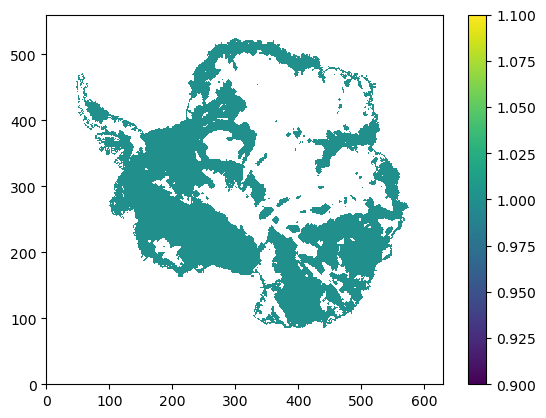

In [15]:
plt.pcolormesh(mask_outice[0,:,:]*mask_land)
plt.colorbar()

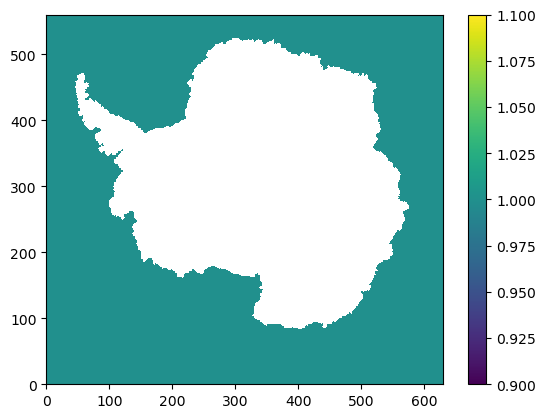

In [16]:
plt.pcolormesh(mask_iceshelf)
plt.colorbar()

For the Antarctic Penin., we need to manually edit the bins 

In [ ]:
### CREATE LATITUDINAL BINS:

In [17]:
lat_bin_limits = np.arange(-90,-50,1.4)

conditions_bin = []
conditions_lastbin = []

for ii in range(0,len(lat_bin_limits)):
    # print(ii)
    # Define your conditions
    conditions1 = (lat_rho >= lat_bin_limits[ii])
    conditions2 = (lat_rho < lat_bin_limits[ii])

    if ii==0:
        conditions_bin = conditions1
        conditions_lastbin = conditions2
        del conditions1, conditions2
    elif ii==1: 
        conditions_bin = np.stack((conditions_bin,conditions1),axis=0)
        conditions_lastbin = np.stack((conditions_lastbin,conditions2),axis=0)
        del conditions1, conditions2
    else:
        conditions1new = np.expand_dims(conditions1, axis=0)
        conditions_bin = np.concatenate((conditions_bin,conditions1new),axis=0)
        conditions2new = np.expand_dims(conditions2, axis=0)
        conditions_lastbin = np.concatenate((conditions_lastbin,conditions2new),axis=0)
        del conditions1, conditions1new
        del conditions2, conditions2new

# Initialize an empty list to store the masked arrays
masked_AllOtherBins_2 = []
masked_PreviousBins_2 = []

# Apply each condition to the array and store the result
for condition in conditions_bin:
    masked_AllOtherBin_2 = np.ma.masked_where(condition, np.ones(h.shape))
    masked_AllOtherBins_2.append(masked_AllOtherBin_2)
for condition in conditions_lastbin:
    masked_PreviousBin_2 = np.ma.masked_where(condition, np.ones(h.shape))
    masked_PreviousBins_2.append(masked_PreviousBin_2)

# cut only the sections required:

# masked_AllOtherBins_2

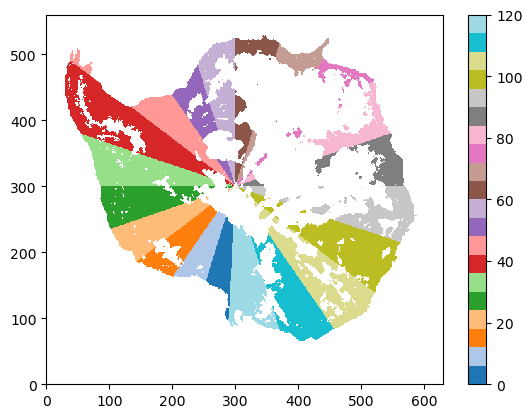

In [42]:

for xx in range(0,119):
    ini=xx
    end=ini-1
    plt.pcolormesh(masked_AllOtherBins[0]*mask_land*mask_shelf*np.ones(h.shape)*xx, vmin=0, vmax=120, cmap='tab20')
    plt.pcolormesh(masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*mask_shelf*np.ones(h.shape)*xx, vmin=0, vmax=120, cmap='tab20')
    plt.pcolormesh(masked_PreviousBins[-1]*mask_land*mask_shelf*np.ones(h.shape)*xx, vmin=0, vmax=120, cmap='tab20')

plt.colorbar()

In [23]:
len(masked_PreviousBins_2)

29

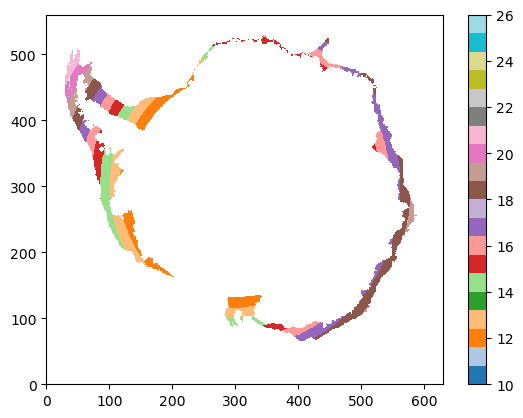

In [26]:
for xx in range(12,26):
    ini=xx
    end=ini-1
    plt.pcolormesh(masked_AllOtherBins_2[ini]*masked_PreviousBins_2[end]*mask_land*mask_shelf*np.ones(h.shape)*xx, vmin=10, vmax=26, cmap='tab20')
plt.colorbar()
# plt.ylim(300,560)
# plt.xlim(0,200)


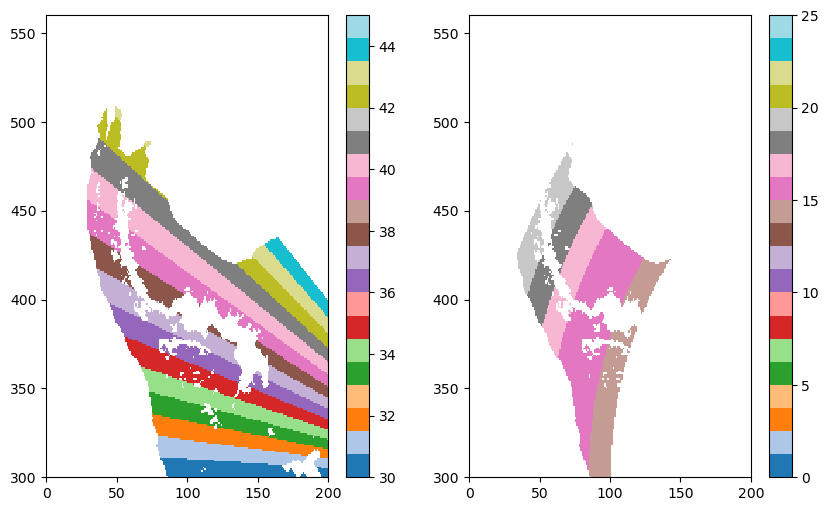

In [45]:
fig = plt.figure(figsize=(10, 6))



ax1 = fig.add_subplot(121)
for xx in range(30,45):
    ini=xx
    end=ini-1
    aa=ax1.pcolormesh(masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*mask_shelf*np.ones(h.shape)*xx, vmin=30, vmax=45, cmap='tab20')
    # aa=ax1.pcolormesh(lon_rho,lat_rho,masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*np.nanmean(mask_zice,axis=0)*mask_shelf*np.ones(h.shape)*xx, vmin=39, vmax=45, cmap='tab20')

# ax1.plot(55*np.ones((100)),np.arange(400,500),'-k')    
ax1.set_ylim(300,560)
ax1.set_xlim(0,200)

plt.colorbar(aa)

ax2 = fig.add_subplot(122)
for xx in range(14,20):
    ini=xx
    end=ini-1
    bb=ax2.pcolormesh(masked_AllOtherBins_2[ini]*masked_PreviousBins_2[end]*mask_land*mask_shelf*np.ones(h.shape)*xx, vmin=0, vmax=25, cmap='tab20')
    # bb=ax2.pcolormesh(lon_rho,lat_rho,masked_AllOtherBins_2[ini]*masked_PreviousBins_2[end]*mask_land*np.nanmean(mask_zice,axis=0)*mask_shelf*np.ones(h.shape)*xx, vmin=0, vmax=20, cmap='tab20')

ax2.set_ylim(300,560)
ax2.set_xlim(0,200)
plt.colorbar(bb)

In [24]:
lon_bin_limits[32]

-81

In [18]:
#   - 41 also decrease longitude til it matches with the tip of the A.P. - DONE.

conditions_bin = []

ii=41

# Define your conditions
conditions1 = (lon_rho >= (lon_bin_limits[ii]-1))

# # Initialize an empty list to store the masked arrays
masked_AllOtherBins_41B = []

# # Apply each condition to the array and store the result
masked_AllOtherBin = np.ma.masked_where(conditions1, np.ones(h.shape))
masked_AllOtherBins_41B.append(masked_AllOtherBin)


In [19]:
# - lon_bin: 0:38 & 44:-1 keep exatcly the same
#   - 39, 40, 41 needs to limit to west A.P. -> WAOM10 index xi_rho = 58. DONE.

# Grid point position on the x-axis
x_position = 58

# Create a mask for all elements past the grid point on the x-axis
mask = np.zeros(masked_AllOtherBins[39].shape, dtype=bool)
mask[:, x_position+1:] = True
masked_lon_bin39 = np.ma.masked_where(mask, masked_AllOtherBins[39])
del mask

mask = np.zeros(masked_AllOtherBins[40].shape, dtype=bool)
mask[:, x_position+1:] = True
# Apply the mask
masked_lon_bin40 = np.ma.masked_where(mask, masked_AllOtherBins[40])
del mask

mask = np.zeros(masked_AllOtherBins[41].shape, dtype=bool)
mask[:, x_position+1:] = True
# Apply the mask
masked_lon_bin41 = np.ma.masked_where(mask, masked_AllOtherBins_41B[0])
del mask


 26 Sept 2024: fixing LONGITUDINAL bins in the deep parts of the FRIS and ROSS ice shelf cavities:


In [54]:
#   - 32:38 needs to limit to west A.P. 

# Grid point position on the x-axis (xi_rho=145 for WAOM10)
x_position = 145

# Create a mask for all elements past the grid point on the x-axis
mask = np.zeros(masked_AllOtherBins[32].shape, dtype=bool)
mask[:, x_position+1:] = True
masked_lon_bin32 = np.ma.masked_where(mask, masked_AllOtherBins[32])
del mask

mask = np.zeros(masked_AllOtherBins[33].shape, dtype=bool)
mask[:, x_position+1:] = True
masked_lon_bin33 = np.ma.masked_where(mask, masked_AllOtherBins[33])
del mask

mask = np.zeros(masked_AllOtherBins[34].shape, dtype=bool)
mask[:, x_position+1:] = True
masked_lon_bin34 = np.ma.masked_where(mask, masked_AllOtherBins[34])
del mask

mask = np.zeros(masked_AllOtherBins[35].shape, dtype=bool)
mask[:, x_position+1:] = True
masked_lon_bin35 = np.ma.masked_where(mask, masked_AllOtherBins[35])
del mask

mask = np.zeros(masked_AllOtherBins[36].shape, dtype=bool)
mask[:, x_position+1:] = True
masked_lon_bin36 = np.ma.masked_where(mask, masked_AllOtherBins[36])
del mask

# for 37,38 needs to be further west:
x_position = 80
mask = np.zeros(masked_AllOtherBins[37].shape, dtype=bool)
mask[:, x_position+1:] = True
masked_lon_bin37 = np.ma.masked_where(mask, masked_AllOtherBins[37])
del mask

x_position = 62
mask = np.zeros(masked_AllOtherBins[38].shape, dtype=bool)
mask[:, x_position+1:] = True
masked_lon_bin38 = np.ma.masked_where(mask, masked_AllOtherBins[38])
del mask

In [55]:
# cut Weddell part of the 39-41 lon_bins: B' version!!!

# Grid point position on the x-axis
x_position = 100

# Create a mask for all elements past the grid point on the x-axis
mask = np.zeros(masked_AllOtherBins[39].shape, dtype=bool)
mask[:, :x_position] = True
masked_lon_bin39B = np.ma.masked_where(mask, masked_AllOtherBins[39])
del mask

mask = np.zeros(masked_AllOtherBins[40].shape, dtype=bool)
mask[:, :x_position] = True
# Apply the mask
masked_lon_bin40B = np.ma.masked_where(mask, masked_AllOtherBins[40])
del mask

mask = np.zeros(masked_AllOtherBins[41].shape, dtype=bool)
mask[:, :x_position] = True
# Apply the mask
# masked_lon_bin41B = np.ma.masked_where(mask, masked_AllOtherBins[41])
del mask

mask = np.zeros(masked_AllOtherBins[42].shape, dtype=bool)
mask[:, :x_position] = True
# Apply the mask
masked_lon_bin42B = np.ma.masked_where(mask, masked_AllOtherBins[42])
del mask

mask = np.zeros(masked_AllOtherBins[43].shape, dtype=bool)
mask[:, :x_position] = True
# Apply the mask
masked_lon_bin43B = np.ma.masked_where(mask, masked_AllOtherBins[43])
del mask


In [22]:
# NOW DOING THE Weddell/FRIS bit on the 32:38 lon_bins:

# Grid point position on the x-axis (xi_rho=145 for WAOM10)
x_position = 145

# Create a mask for all elements past the grid point on the x-axis
mask = np.zeros(masked_AllOtherBins[32].shape, dtype=bool)
mask[:, :x_position] = True
masked_lon_bin32B = np.ma.masked_where(mask, masked_AllOtherBins[32])
del mask

mask = np.zeros(masked_AllOtherBins[33].shape, dtype=bool)
mask[:, :x_position] = True
masked_lon_bin33B = np.ma.masked_where(mask, masked_AllOtherBins[33])
del mask

mask = np.zeros(masked_AllOtherBins[34].shape, dtype=bool)
mask[:, :x_position] = True
masked_lon_bin34B = np.ma.masked_where(mask, masked_AllOtherBins[34])
del mask

mask = np.zeros(masked_AllOtherBins[35].shape, dtype=bool)
mask[:, :x_position] = True
masked_lon_bin35B = np.ma.masked_where(mask, masked_AllOtherBins[35])
del mask
# 
mask = np.zeros(masked_AllOtherBins[36].shape, dtype=bool)
mask[:, :x_position] = True
masked_lon_bin36B = np.ma.masked_where(mask, masked_AllOtherBins[36])
del mask

mask = np.zeros(masked_AllOtherBins[37].shape, dtype=bool)
mask[:, :x_position] = True
masked_lon_bin37B = np.ma.masked_where(mask, masked_AllOtherBins[37])
del mask

mask = np.zeros(masked_AllOtherBins[38].shape, dtype=bool)
mask[:, :x_position] = True
masked_lon_bin38B = np.ma.masked_where(mask, masked_AllOtherBins[38])
del mask

In [40]:
len(masked_AllOtherBins)

119

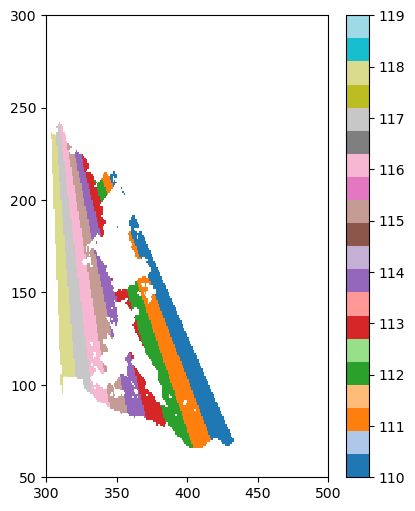

In [23]:
# now fixing Ross:

fig = plt.figure(figsize=(10, 6))

ax1 = fig.add_subplot(121)
for xx in range(110,119):
    ini=xx
    end=ini-1
    aa=ax1.pcolormesh(masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*mask_shelf*np.ones(h.shape)*xx, vmin=110, vmax=119, cmap='tab20')
    # aa=ax1.pcolormesh(lon_rho,lat_rho,masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*np.nanmean(mask_zice,axis=0)*mask_shelf*np.ones(h.shape)*xx, vmin=39, vmax=45, cmap='tab20')

# ax1.plot(55*np.ones((100)),np.arange(400,500),'-k')    
ax1.set_ylim(50,300)
ax1.set_xlim(300,500)

plt.colorbar(aa)


In [24]:
# 113:116

# B'version = ROSS side
# Grid point position on the eta-axis (eta_rho=105 for WAOM10)
y_position = 105

# Create a mask for all elements past the grid point on the x-axis
mask = np.zeros(masked_AllOtherBins[113].shape, dtype=bool)
mask[:y_position, :] = True
masked_lon_bin113B = np.ma.masked_where(mask, masked_AllOtherBins[113])
del mask

mask = np.zeros(masked_AllOtherBins[114].shape, dtype=bool)
mask[:y_position, :] = True
masked_lon_bin114B = np.ma.masked_where(mask, masked_AllOtherBins[114])
del mask

mask = np.zeros(masked_AllOtherBins[115].shape, dtype=bool)
mask[:y_position, :] = True
masked_lon_bin115B = np.ma.masked_where(mask, masked_AllOtherBins[115])
del mask

mask = np.zeros(masked_AllOtherBins[116].shape, dtype=bool)
mask[:y_position, :] = True
masked_lon_bin116B = np.ma.masked_where(mask, masked_AllOtherBins[116])
del mask


In [25]:
# 113:116

# A'version = East Ant. side
# Grid point position on the eta-axis (eta_rho=105 for WAOM10)
y_position = 105

# Create a mask for all elements past the grid point on the x-axis
mask = np.zeros(masked_AllOtherBins[113].shape, dtype=bool)
mask[y_position+1:, :] = True
masked_lon_bin113 = np.ma.masked_where(mask, masked_AllOtherBins[113])
del mask

mask = np.zeros(masked_AllOtherBins[114].shape, dtype=bool)
mask[y_position+1:, :] = True
masked_lon_bin114 = np.ma.masked_where(mask, masked_AllOtherBins[114])
del mask

mask = np.zeros(masked_AllOtherBins[115].shape, dtype=bool)
mask[y_position+1:, :] = True
masked_lon_bin115 = np.ma.masked_where(mask, masked_AllOtherBins[115])
del mask

mask = np.zeros(masked_AllOtherBins[116].shape, dtype=bool)
mask[y_position+1:, :] = True
masked_lon_bin116 = np.ma.masked_where(mask, masked_AllOtherBins[116])
del mask


Get Latitude bins now

In [65]:
# - lat_bin: 13:19
#   - 13 needs to match lat/lon with the modified lon_bin[42 - only Wed]

# Grid point position on the x-axis
x_position = 55
y_position = 400

# for latbin 17/16:
x_position2 = 60
y_position2 = 407

x_position3 = 200

# mask = np.zeros(masked_AllOtherBins_2[20].shape, dtype=bool)
# mask[:y_position, :] = True
# mask[:, :x_position] = True
# masked_lat_bin20 = np.ma.masked_where(mask, masked_AllOtherBins_2[20])
# del mask

mask = np.zeros(masked_AllOtherBins_2[19].shape, dtype=bool)
mask[:y_position, :] = True
mask[:, :x_position] = True
masked_lat_bin19 = np.ma.masked_where(mask, masked_AllOtherBins_2[19])
del mask

mask = np.zeros(masked_AllOtherBins_2[18].shape, dtype=bool)
mask[:y_position, :] = True
mask[:, :x_position2] = True
mask[:, x_position3+1:] = True
masked_lat_bin18 = np.ma.masked_where(mask, masked_AllOtherBins_2[18])
del mask

mask = np.zeros(masked_AllOtherBins_2[17].shape, dtype=bool)
mask[:y_position2, :] = True
mask[:, :x_position2] = True
mask[:, x_position3+1:] = True
masked_lat_bin17 = np.ma.masked_where(mask, masked_AllOtherBins_2[17])
del mask

mask = np.zeros(masked_AllOtherBins_2[16].shape, dtype=bool)
mask[:y_position, :] = True
mask[:, :x_position2] = True
mask[:, x_position3+1:] = True
masked_lat_bin16 = np.ma.masked_where(mask, masked_AllOtherBins_2[16])
del mask

mask = np.zeros(masked_AllOtherBins_2[15].shape, dtype=bool)
mask[:y_position, :] = True
mask[:, :x_position] = True
mask[:, x_position3+1:] = True
masked_lat_bin15 = np.ma.masked_where(mask, masked_AllOtherBins_2[15])
del mask

mask = np.zeros(masked_AllOtherBins_2[14].shape, dtype=bool)
mask[:y_position, :] = True
mask[:, :x_position] = True
mask[:, x_position3+1:] = True
masked_lat_bin14 = np.ma.masked_where(mask, masked_AllOtherBins_2[14])
del mask

mask = np.zeros(masked_AllOtherBins_2[13].shape, dtype=bool)
mask[:y_position, :] = True
mask[:, :x_position] = True
mask[:, x_position3+1:] = True
masked_lat_bin13 = np.ma.masked_where(mask, masked_AllOtherBins_2[13])
del mask


In [27]:
#   - 42 - increase longitude til it matches with the end of 41B

conditions_bin = []

ii=41

# Define your conditions
conditions1 = (lon_rho < (lon_bin_limits[ii]-1))

# # Initialize an empty list to store the masked arrays
masked_PreviousBins_41B = []

# # Apply each condition to the array and store the result
masked_PreviousBin = np.ma.masked_where(conditions1, np.ones(h.shape))
masked_PreviousBins_41B.append(masked_PreviousBin)



In [28]:
# cut Weddell part of the 42/43 lon_bins: B' version!!!

# Grid point position on the x-axis
x_position = 100

mask = np.zeros(masked_AllOtherBins[42].shape, dtype=bool)
mask[:, x_position+1:] = True
# Apply the mask
masked_lon_bin42C = np.ma.masked_where(mask, masked_AllOtherBins[42])
del mask

mask = np.zeros(masked_AllOtherBins[43].shape, dtype=bool)
mask[:, x_position+1:] = True
# Apply the mask
masked_lon_bin43C = np.ma.masked_where(mask, masked_AllOtherBins[43])
del mask



In [29]:
# now combine the lon and lat bins:

##

# lon bin: 32:41 Want side:
# 
# lat_bin: 13:19 (West A.P.)
# lon_bin: 32B:41B (FRIS bit) - add to lon_bin 44
# lon_bin: 42B:43B (FRIS too) - add to lon_bin 44
# lonbin: 113:116 (EAnt side)
# lonbin: 113B:116B (Ross bit) - add to lon_bin 117
#
# - lon_bin: 0:32 & 44:113 & 116:119 keep exatcly the same


#### plot bits to check:

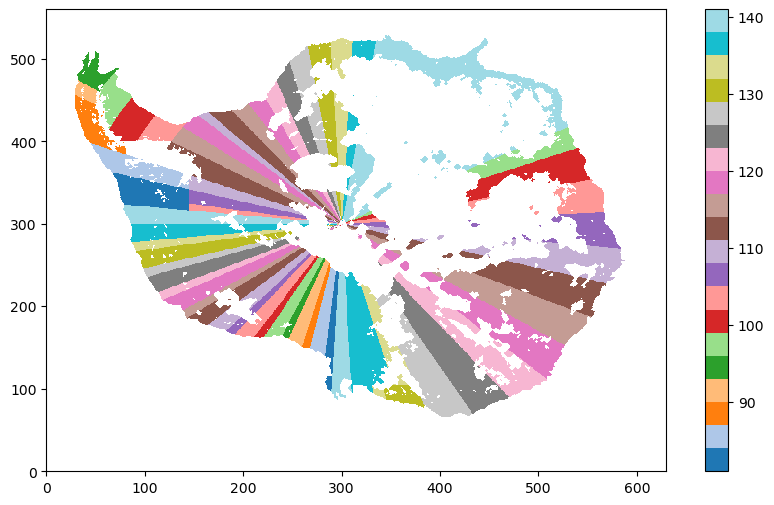

In [190]:
# Final check with individual modified bins to make sure it's all correct!

fig = plt.figure(figsize=(10, 6))

    
plt.pcolormesh(masked_AllOtherBins[0]*mask_land*mask_shelf*np.ones(h.shape)*xx, vmin=0, vmax=40, cmap='tab20')

# from start to West Antarctic
for xx in range(1,32):
    ini=xx
    end=ini-1
    plt.pcolormesh(masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*mask_shelf*np.ones(h.shape)*xx, vmin=0, vmax=31, cmap='tab20')

# West Ant.
plt.pcolormesh(masked_lon_bin32*masked_PreviousBins[31]*mask_land*mask_shelf*np.ones(h.shape)*32, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin33*masked_PreviousBins[32]*mask_land*mask_shelf*np.ones(h.shape)*33, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin34*masked_PreviousBins[33]*mask_land*mask_shelf*np.ones(h.shape)*34, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin35*masked_PreviousBins[34]*mask_land*mask_shelf*np.ones(h.shape)*35, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin36*masked_PreviousBins[35]*mask_land*mask_shelf*np.ones(h.shape)*36, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin37*masked_PreviousBins[36]*mask_land*mask_shelf*np.ones(h.shape)*37, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin38*masked_PreviousBins[37]*mask_land*mask_shelf*np.ones(h.shape)*38, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin39*masked_PreviousBins[38]*mask_land*mask_shelf*np.ones(h.shape)*39, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin40*masked_PreviousBins[39]*mask_land*mask_shelf*np.ones(h.shape)*40, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin41*masked_PreviousBins[40]*mask_land*mask_shelf*np.ones(h.shape)*42, vmin=32, vmax=80, cmap='tab20')

# Ant. Penins. tip
plt.pcolormesh(masked_lon_bin42C[0]*masked_PreviousBins_41B[0]*masked_PreviousBins_2[19]*mask_land*mask_shelf*np.ones(h.shape)*43, vmin=32, vmax=80, cmap='tab20')
# not need 43C!
# plt.pcolormesh(masked_lon_bin43C[0]*masked_PreviousBins[42]*masked_PreviousBins_2[19]*mask_land*mask_shelf*np.ones(h.shape)*44, vmin=32, vmax=80, cmap='tab20')

# East Ant. Penins
plt.pcolormesh(masked_lat_bin19*masked_PreviousBins_2[18]*mask_land*mask_shelf*np.ones(h.shape)*45, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lat_bin18*masked_PreviousBins_2[17]*mask_land*mask_shelf*np.ones(h.shape)*46, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lat_bin17*masked_PreviousBins_2[16]*mask_land*mask_shelf*np.ones(h.shape)*47, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lat_bin16*masked_PreviousBins_2[15]*mask_land*mask_shelf*np.ones(h.shape)*48, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lat_bin15*masked_PreviousBins_2[14]*mask_land*mask_shelf*np.ones(h.shape)*49, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lat_bin14*masked_PreviousBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*50, vmin=32, vmax=80, cmap='tab20')

# SW Weddell corner
plt.pcolormesh(masked_lon_bin32B*masked_PreviousBins[31]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*51, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin33B*masked_PreviousBins[32]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*52, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin34B*masked_PreviousBins[33]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*53, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin35B*masked_PreviousBins[34]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*54, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin36B*masked_PreviousBins[35]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*55, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin37B*masked_PreviousBins[36]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*56, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin38B*masked_PreviousBins[37]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*57, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin39B*masked_PreviousBins[38]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*58, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin40B*masked_PreviousBins[39]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*59, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin41B*masked_PreviousBins[40]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*60, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin42B*masked_PreviousBins[41]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*61, vmin=32, vmax=80, cmap='tab20')

# plt.pcolormesh(masked_lon_bin42B*masked_PreviousBins[38]*masked_AllOtherBins_2[13]*mask_land*mask_shelf*np.ones(h.shape)*60, vmin=32, vmax=80, cmap='tab20')
plt.pcolormesh(masked_lon_bin43B*masked_PreviousBins[42]*mask_land*mask_shelf*np.ones(h.shape)*62, vmin=32, vmax=80, cmap='tab20')

# # From Weddell to the Ross/EAnt fix:
for xx in range(44,81):
    ini=xx
    end=ini-1
    plt.pcolormesh(masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*mask_shelf*np.ones(h.shape)*(xx+16), vmin=41, vmax=80, cmap='tab20')
for xx in range(81,113):
    ini=xx
    end=ini-1
    plt.pcolormesh(masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*mask_shelf*np.ones(h.shape)*(xx+16), vmin=81, vmax=141, cmap='tab20')


plt.pcolormesh(masked_lon_bin113*masked_PreviousBins[112]*mask_land*mask_shelf*np.ones(h.shape)*(113+16), vmin=81, vmax=141, cmap='tab20')
plt.pcolormesh(masked_lon_bin114*masked_PreviousBins[113]*mask_land*mask_shelf*np.ones(h.shape)*(114+16), vmin=81, vmax=141, cmap='tab20')
plt.pcolormesh(masked_lon_bin115*masked_PreviousBins[114]*mask_land*mask_shelf*np.ones(h.shape)*(115+16), vmin=81, vmax=141, cmap='tab20')
plt.pcolormesh(masked_lon_bin116*masked_PreviousBins[115]*mask_land*mask_shelf*np.ones(h.shape)*(116+16), vmin=81, vmax=141, cmap='tab20')

plt.pcolormesh(masked_lon_bin113B*masked_PreviousBins[112]*mask_land*mask_shelf*np.ones(h.shape)*(117+16), vmin=81, vmax=141, cmap='tab20')
plt.pcolormesh(masked_lon_bin114B*masked_PreviousBins[113]*mask_land*mask_shelf*np.ones(h.shape)*(118+16), vmin=81, vmax=141, cmap='tab20')
plt.pcolormesh(masked_lon_bin115B*masked_PreviousBins[114]*mask_land*mask_shelf*np.ones(h.shape)*(119+16), vmin=81, vmax=141, cmap='tab20')
plt.pcolormesh(masked_lon_bin116B*masked_PreviousBins[115]*mask_land*mask_shelf*np.ones(h.shape)*(120+16), vmin=81, vmax=141, cmap='tab20')

for xx in range(117,119):
    ini=xx
    end=ini-1
    plt.pcolormesh(masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*mask_shelf*np.ones(h.shape)*(xx+19), vmin=81, vmax=141, cmap='tab20')


plt.pcolormesh(masked_PreviousBins[-1]*mask_land*mask_shelf*np.ones(h.shape)*140, vmin=81, vmax=141, cmap='tab20')

# plt.plot(55*np.ones((100)),np.arange(400,500),'-k')    
# plt.plot(np.arange(50,130),400*np.ones((80)),'-k')    
# plt.plot(60*np.ones((100)),np.arange(400,500),'--k')    
# plt.plot(np.arange(50,130),420*np.ones((80)),'--k')    

# plt.ylim(300,560)
# plt.xlim(0,200)
plt.colorbar()

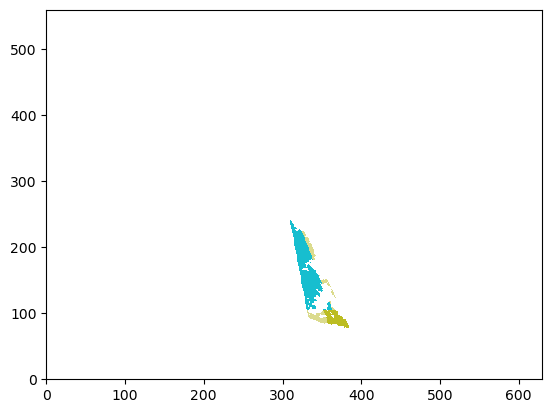

In [152]:
plt.pcolormesh(masked_lon_bin113*masked_PreviousBins[112]*mask_land*mask_shelf*np.ones(h.shape)*(113+17), vmin=81, vmax=140, cmap='tab20')
plt.pcolormesh(masked_lon_bin114*masked_PreviousBins[113]*mask_land*mask_shelf*np.ones(h.shape)*(114+17), vmin=81, vmax=140, cmap='tab20')
plt.pcolormesh(masked_lon_bin115*masked_PreviousBins[114]*mask_land*mask_shelf*np.ones(h.shape)*(115+17), vmin=81, vmax=140, cmap='tab20')
plt.pcolormesh(masked_lon_bin116*masked_PreviousBins[115]*mask_land*mask_shelf*np.ones(h.shape)*(116+17), vmin=81, vmax=140, cmap='tab20')
plt.pcolormesh(masked_lon_bin113B*masked_PreviousBins[112]*mask_land*mask_shelf*np.ones(h.shape)*(117+17), vmin=81, vmax=140, cmap='tab20')
plt.pcolormesh(masked_lon_bin114B*masked_PreviousBins[113]*mask_land*mask_shelf*np.ones(h.shape)*(118+17), vmin=81, vmax=140, cmap='tab20')
plt.pcolormesh(masked_lon_bin115B*masked_PreviousBins[114]*mask_land*mask_shelf*np.ones(h.shape)*(119+17), vmin=81, vmax=140, cmap='tab20')
plt.pcolormesh(masked_lon_bin116B*masked_PreviousBins[115]*mask_land*mask_shelf*np.ones(h.shape)*(120+17), vmin=81, vmax=140, cmap='tab20')

# for xx in range(116,119):
#     ini=xx
#     end=ini-1
#     plt.pcolormesh(masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*mask_shelf*np.ones(h.shape)*(xx+21), vmin=81, vmax=140, cmap='tab20')



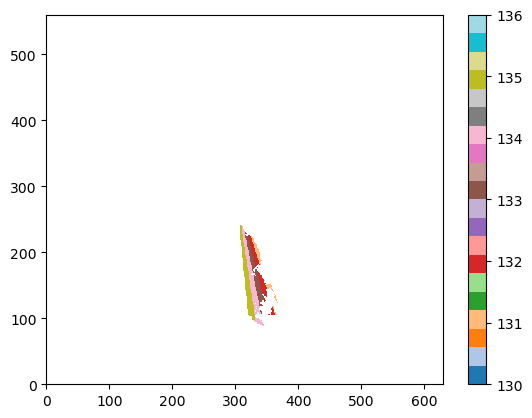

In [185]:
# i=131:134
plt.pcolormesh(masked_lon_bin113B*masked_PreviousBins[112]*mask_land*mask_shelf*np.ones(h.shape)*131, vmin=130, vmax=136, cmap='tab20')
plt.pcolormesh(masked_lon_bin114B*masked_PreviousBins[113]*mask_land*mask_shelf*np.ones(h.shape)*132, vmin=130, vmax=136, cmap='tab20')
plt.pcolormesh(masked_lon_bin115B*masked_PreviousBins[114]*mask_land*mask_shelf*np.ones(h.shape)*133, vmin=130, vmax=136, cmap='tab20')
# i=135
ini=116
end=ini-1
plt.pcolormesh(masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*mask_shelf*np.ones(h.shape)*134, vmin=130, vmax=136, cmap='tab20')

ini=117
end=ini-1
plt.pcolormesh(masked_AllOtherBins[ini]*masked_PreviousBins[end]*mask_land*mask_shelf*np.ones(h.shape)*135, vmin=130, vmax=136, cmap='tab20')
plt.colorbar()

In [188]:
#### creat masked_lon-lat-lon_bins combined & save into a netcdf file

masked_lonlatBins = []

# 1) from lon_bin[0] to lon_bin[38]:
# 1st bin:
masked_lonlatBins.append(masked_AllOtherBins[0])

# 2nd to 32th lon_bin:
for xx in range(1,32):
    ini=xx
    end=ini-1
    masked_lonlatBins.append(masked_AllOtherBins[ini]*masked_PreviousBins[end])

# 2) West side of the Antarctic Peninsula (modified lon_bin[39-41])
masked_lonlatBins.append(masked_lon_bin32*masked_PreviousBins[31]) #33
masked_lonlatBins.append(masked_lon_bin33*masked_PreviousBins[32])
masked_lonlatBins.append(masked_lon_bin34*masked_PreviousBins[33])
masked_lonlatBins.append(masked_lon_bin35*masked_PreviousBins[34])
masked_lonlatBins.append(masked_lon_bin36*masked_PreviousBins[35])
masked_lonlatBins.append(masked_lon_bin37*masked_PreviousBins[36])
masked_lonlatBins.append(masked_lon_bin38*masked_PreviousBins[37])
masked_lonlatBins.append(masked_lon_bin39*masked_PreviousBins[38])
masked_lonlatBins.append(masked_lon_bin40*masked_PreviousBins[39])
masked_lonlatBins.append(masked_lon_bin41*masked_PreviousBins[40]) #42

# 3) Ant. Peninsula tip
masked_lonlatBins.append(masked_lon_bin42C[0]*masked_PreviousBins_41B[0]*masked_PreviousBins_2[19])

# 4) East Ant. Penin (lat_bin[14:19])
masked_lonlatBins.append(masked_lat_bin19*masked_PreviousBins_2[18]) #44
masked_lonlatBins.append(masked_lat_bin18*masked_PreviousBins_2[17])
masked_lonlatBins.append(masked_lat_bin17*masked_PreviousBins_2[16])
masked_lonlatBins.append(masked_lat_bin16*masked_PreviousBins_2[15])
masked_lonlatBins.append(masked_lat_bin15*masked_PreviousBins_2[14])
masked_lonlatBins.append(masked_lat_bin14*masked_PreviousBins_2[13]) #49

# 5) SW corner Weddell (modified lon_bin[39-42])
masked_lonlatBins.append(masked_lon_bin32B*masked_PreviousBins[31]*masked_AllOtherBins_2[13]) #50
masked_lonlatBins.append(masked_lon_bin33B*masked_PreviousBins[32]*masked_AllOtherBins_2[13])
masked_lonlatBins.append(masked_lon_bin34B*masked_PreviousBins[33]*masked_AllOtherBins_2[13])
masked_lonlatBins.append(masked_lon_bin35B*masked_PreviousBins[34]*masked_AllOtherBins_2[13])
masked_lonlatBins.append(masked_lon_bin36B*masked_PreviousBins[35]*masked_AllOtherBins_2[13])
masked_lonlatBins.append(masked_lon_bin37B*masked_PreviousBins[36]*masked_AllOtherBins_2[13])
masked_lonlatBins.append(masked_lon_bin38B*masked_PreviousBins[37]*masked_AllOtherBins_2[13])
masked_lonlatBins.append(masked_lon_bin39B*masked_PreviousBins[38]*masked_AllOtherBins_2[13])
masked_lonlatBins.append(masked_lon_bin40B*masked_PreviousBins[39]*masked_AllOtherBins_2[13]) #58
#
masked_lonlatBins.append(masked_lon_bin41B*masked_PreviousBins[40]*masked_AllOtherBins_2[13])
masked_lonlatBins.append(masked_lon_bin42B*masked_PreviousBins[41]*masked_AllOtherBins_2[13])
#
# masked_lonlatBins.append(masked_lon_bin42B*masked_PreviousBins[38]*masked_AllOtherBins_2[13]) #60
               
masked_lonlatBins.append(masked_lon_bin43B*masked_PreviousBins[42])

# 6) lon_bin[44] to before EAnt/Ross fix: 
for xx in range(44,113): #62:(131)
    ini=xx
    end=ini-1
    masked_lonlatBins.append(masked_AllOtherBins[ini]*masked_PreviousBins[end])

# 7) Bits from EAnt+Ross:
masked_lonlatBins.append(masked_lon_bin113*masked_PreviousBins[112]) #131
masked_lonlatBins.append(masked_lon_bin114*masked_PreviousBins[113]) #132
masked_lonlatBins.append(masked_lon_bin115*masked_PreviousBins[114]) #133
masked_lonlatBins.append(masked_lon_bin116*masked_PreviousBins[115]) #134
masked_lonlatBins.append(masked_lon_bin113B*masked_PreviousBins[112]) #135
masked_lonlatBins.append(masked_lon_bin114B*masked_PreviousBins[113]) #136
masked_lonlatBins.append(masked_lon_bin115B*masked_PreviousBins[114]) #137
masked_lonlatBins.append(masked_lon_bin116B*masked_PreviousBins[115])

# 8) Remaining of Ross:
for xx in range(117,119): #139:
    ini=xx
    end=ini-1
    masked_lonlatBins.append(masked_AllOtherBins[ini]*masked_PreviousBins[end])
    
# 9) last bin:
masked_lonlatBins.append(masked_PreviousBins[-1])

In [189]:
# convert to xarray:
len(masked_lonlatBins)

# Convert the list of masked arrays to a 3D numpy array
data = np.stack([ma.filled(np.nan) for ma in masked_lonlatBins])

# Create a mask array (also 3D)
mask = np.stack([ma.mask for ma in masked_lonlatBins])

# Combine the data and mask arrays into a single DataArray
# da = xr.DataArray(data, dims=["time", "y", "x"])
da = xr.DataArray(data, dims=["lon_bin", "eta_rho", "xi_rho"])
da = da.where(~mask)

da.to_netcdf(files_path + 'WAOM10_masked_lonlatBins_v2.nc', mode='w', format="NETCDF4")

In [174]:
print(files_path + 'WAOM10_masked_lonlatBins_v2.nc')

/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/WAOM10_masked_lonlatBins_v2.nc


In [234]:
116-43

73

In [237]:
lon_bin_midpts = np.arange(-178.5,180,3)
lat_bin_midpts = np.arange(lon_bin_midpts[41],lon_bin_midpts[43],0.6667)
lon_bin_midpts_WRoss = np.arange(170,172,.5)

# define lonlat
lonlat_bin_midpts = np.empty((141))
lonlat_bin_midpts[0:41] = lon_bin_midpts[0:41]
lonlat_bin_midpts[41:50] = lat_bin_midpts
lonlat_bin_midpts[50:60] = lon_bin_midpts[31:41]
lonlat_bin_midpts[60:133] = lon_bin_midpts[43:116]
lonlat_bin_midpts[133:137] = lon_bin_midpts_WRoss
lonlat_bin_midpts[137:] = lon_bin_midpts[116:]

In [238]:
lon_bin_midpts.shape

(120,)

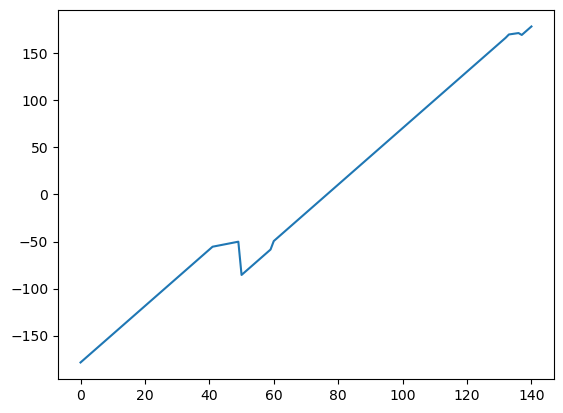

In [239]:
plt.plot(lonlat_bin_midpts)
# plt.plot(np.arange(170,172,.5),'.')

In [205]:
print(lon_bin_midpts[116], #i139
lon_bin_midpts[117]) #i139

169.5 172.5


#### below create the masked_lonBins and save into a netcdf file:

this is the original with only longitudinal bins every 3deg

In [23]:
masked_lonBins = []

# 1st bin:
masked_lonBins.append(masked_AllOtherBins[0])

# 2nd to 2nd-last bins:
for xx in range(1,119):
    ini=xx
    end=ini-1
    masked_lonBins.append(masked_AllOtherBins[ini]*masked_PreviousBins[end])
    
# last bin:
masked_lonBins.append(masked_PreviousBins[-1])

In [32]:
# convert to xarray:
len(masked_lonBins)

# Convert the list of masked arrays to a 3D numpy array
data = np.stack([ma.filled(np.nan) for ma in masked_lonBins])

# Create a mask array (also 3D)
mask = np.stack([ma.mask for ma in masked_lonBins])

# Combine the data and mask arrays into a single DataArray
# da = xr.DataArray(data, dims=["time", "y", "x"])
da = xr.DataArray(data, dims=["lon_bin", "eta_rho", "xi_rho"])
da = da.where(~mask)

# da.to_netcdf(files_path + 'WAOM10_masked_lonBins.nc', mode='w', format="NETCDF4")

In [34]:
# plt.pcolormesh(da[5,:]*mask_shelf*mask_zice*mask_land)
# plt.colorbar()

#### old stuffs below:

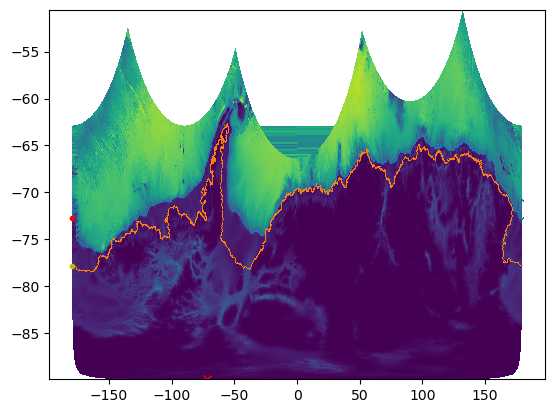

In [210]:
plt.pcolormesh(lon_rho, lat_rho,h)
plt.plot(lon_along_10km, lat_along_10km,',')
plt.plot(lon_along_10km_CF, lat_along_10km_CF,',')
plt.plot(lon_along_10km.isel(contour_index_array=int(ind_1500[0])), lat_along_10km.isel(contour_index_array=int(ind_1500[0])),'.r')
plt.plot(lon_along_10km_CF.isel(contour_index_array=int(ind_CF[0])), lat_along_10km_CF.isel(contour_index_array=int(ind_CF[0])),'.y')

plt.plot(lon_rho[300,298],lat_rho[300,298],'xr')


In [213]:
xcon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_x_contour.csv")
x_contour = xcon_np.tolist()
ycon_np=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_1500m_y_contour.csv")
y_contour = ycon_np.tolist()

In [212]:
xcon_np_CF=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_CF_x_contour.csv")
x_contour_CF = xcon_np_CF.tolist()
ycon_np_CF=np.loadtxt("/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/WAOM10_CF_y_contour.csv")
y_contour_CF = ycon_np_CF.tolist()

In [214]:
# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)
# print(diff_ind)
# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[int(y_contour[ii]), int(x_contour[ii])]